In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import sys
from operator import itemgetter

import seaborn
seaborn.set()
from matplotlib import pyplot

logging.basicConfig(stream=sys.stdout, level=logging.getLevelName('INFO'))

def plot_rdm(similarities, title, ax):
    labels = similarities['stimulus_sentence'].values
    if isinstance(labels[0], tuple):
        labels = map(itemgetter(0), labels)
    labels = [label[:20] for label in labels]
    seaborn.heatmap(similarities, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(labels, rotation=90)
    ax.get_yaxis().set_visible(False)

def plot_rdms(rdm_titles, axes):
    for (rdm, title), ax in zip(rdm_titles, axes):
        plot_rdm(rdm, title, ax)


stories = ['Boar', 'KingOfBirds', 'Elvis', 'HighSchool']

## Neural Data

In [3]:
from neural_nlp.neural_data import load_rdm_sentences
from neural_nlp.stimuli import load_stimuli

boar_data = load_rdm_sentences(story='Boar')
boar_data = boar_data.mean(dim='subject')
print(boar_data.shape, boar_data.dims)


(44, 47, 47) ('region', 'stimulus', 'stimulus')


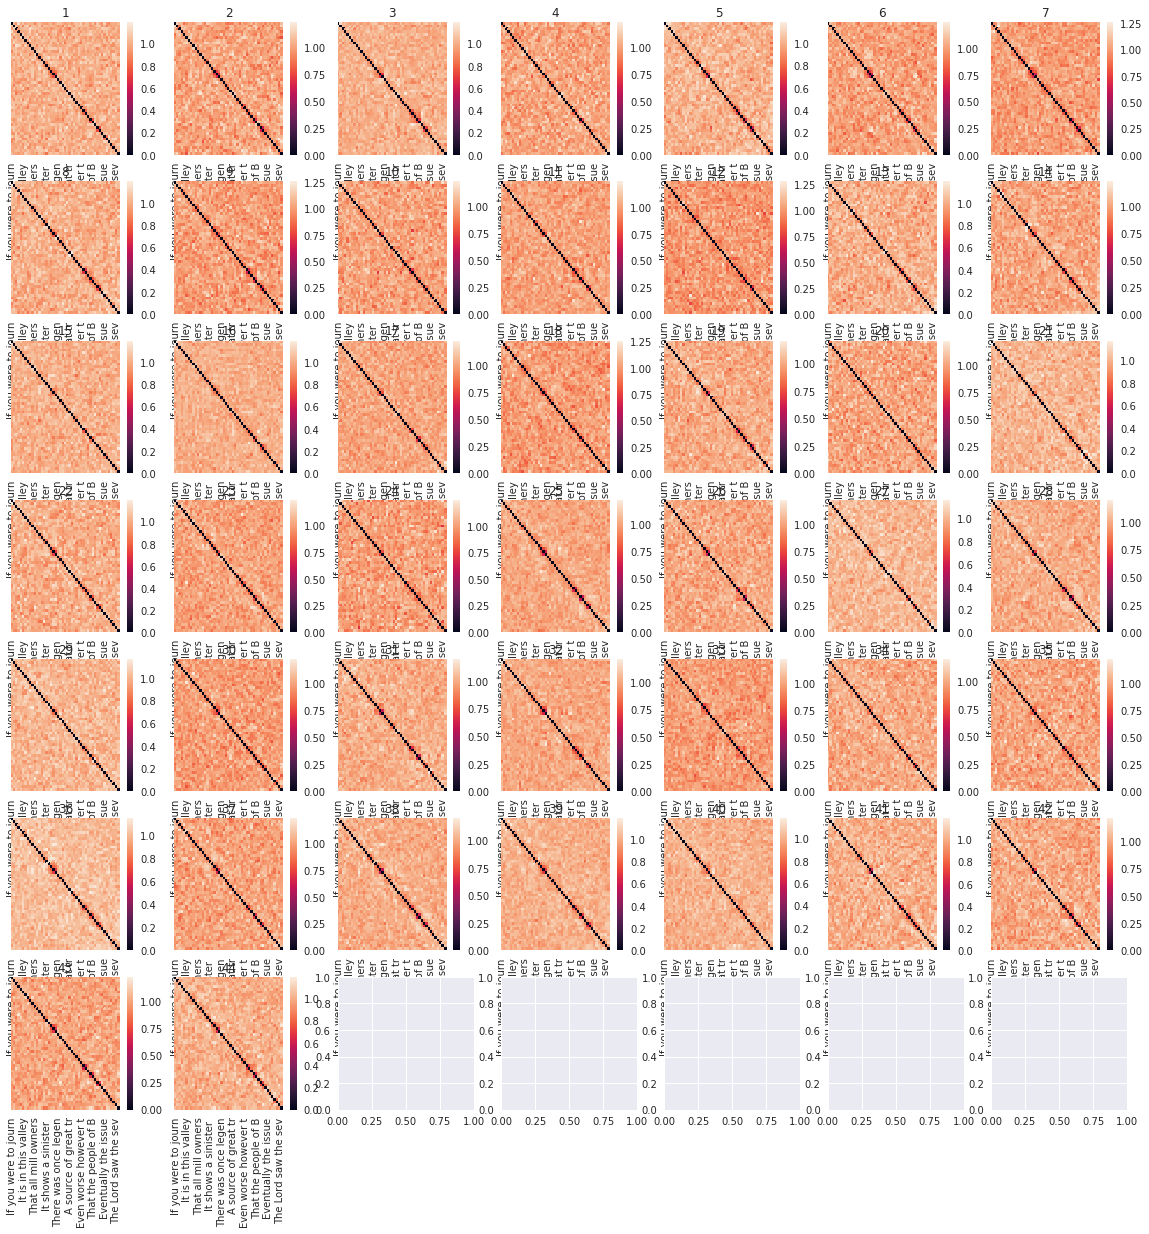

In [4]:
%matplotlib inline
import numpy as np

num_rows_cols = int(np.ceil(np.sqrt(len(boar_data['region']))))
fig, axes = pyplot.subplots(num_rows_cols, num_rows_cols, figsize=(20, 20))

generator = ((boar_data.sel(region=region), region) for region in boar_data['region'].values)
plot_rdms(generator, axes.flatten())

pyplot.savefig('results/RDM-neural-Boar.svg')
pyplot.savefig('results/RDM-neural-Boar.png')
fig

### Inter-region similarity

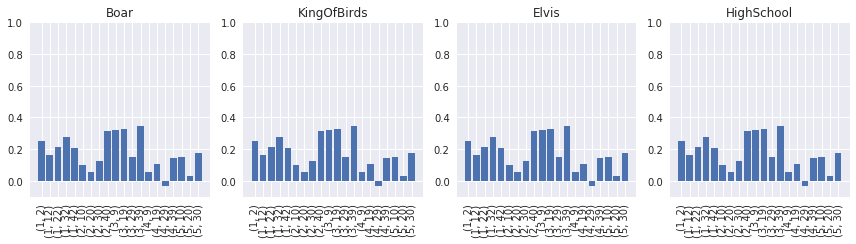

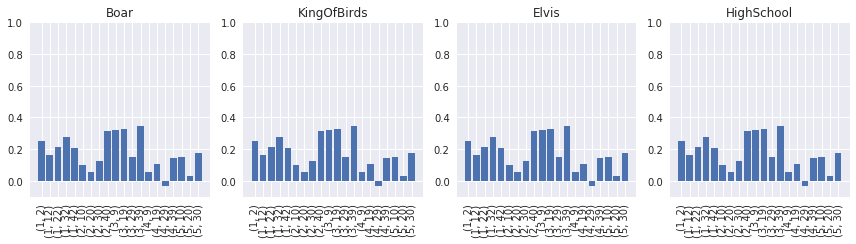

In [6]:
import itertools

from brainscore.metrics.rdm import RDMSimilarity

similarity = RDMSimilarity()
region_combinations = list(itertools.combinations(boar_data['region'].values, 2))[:200:10]

fig, axes = pyplot.subplots(1, len(stories), figsize=(12, 3.5))
for story, ax in zip(stories, axes):
    scores = {}
    for region_combination in region_combinations:
        rdms = [boar_data.sel(region=region) for region in region_combination]
        score = similarity(*rdms)
        scores[region_combination] = score
    x, y = list(scores.keys()), list(scores.values())
    ax.bar(range(len(x)), y)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(list(map(str, x)), rotation='vertical')
    ax.set_ylim(-.1, 1)
    ax.set_title(story)
fig.tight_layout()
pyplot.savefig('results/scores-interneural.svg')
pyplot.savefig('results/scores-interneural.png')
fig

## Models

In [10]:
% env MKL_THREADING_LAYER=GNU
models = ['skip-thoughts', 'lm_1b', 'rntn']

env: MKL_THREADING_LAYER=GNU


### Model RDMs

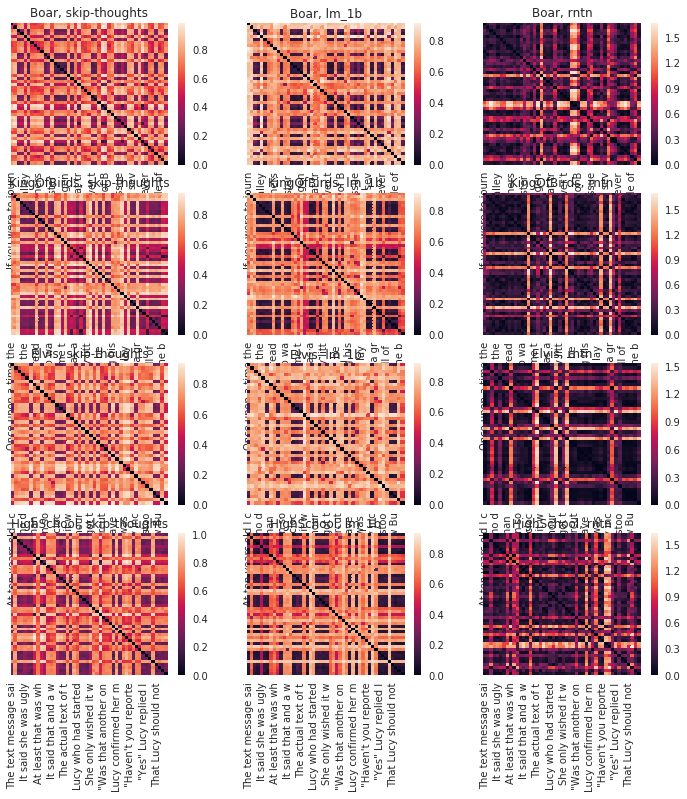

In [11]:
% matplotlib inline

from matplotlib import pyplot

from neural_nlp.models import get_activations
from neural_nlp.stimuli import load_stimuli
from mkgu.metrics.rdm import RDM

rdm = RDM()

def model_rdm_generator():
    for story in stories:
        for model_name in models:
            # feed in sentences in context, i.e. with continuity
            encodings = get_activations(model_name, 'naturalistic-neural-reduced.{}'.format(story))
            similarities = rdm(encodings)
            yield similarities, '{}, {}'.format(story, model_name)

fig, axes = pyplot.subplots(len(stories), len(models), figsize=(12, 12))
plot_rdms(model_rdm_generator(), axes.flatten())
pyplot.savefig('results/RDM-models.svg')
pyplot.savefig('results/RDM-models.png')
fig


### Inter-model similarity

{('skip-thoughts', 'lm_1b'): 0.7906700318790121, ('skip-thoughts', 'rntn'): 0.08557950521413818, ('lm_1b', 'rntn'): -0.03837452698017627}


{('skip-thoughts', 'lm_1b'): 0.8052811360992755, ('skip-thoughts', 'rntn'): 0.14034107144857022, ('lm_1b', 'rntn'): 0.1252880070011254}


{('skip-thoughts', 'lm_1b'): 0.7881961917454933, ('skip-thoughts', 'rntn'): -0.03307929056999651, ('lm_1b', 'rntn'): -0.0863060879768126}


{('skip-thoughts', 'lm_1b'): 0.8619874312026965, ('skip-thoughts', 'rntn'): -0.03861196197319735, ('lm_1b', 'rntn'): -0.014796781635264572}


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


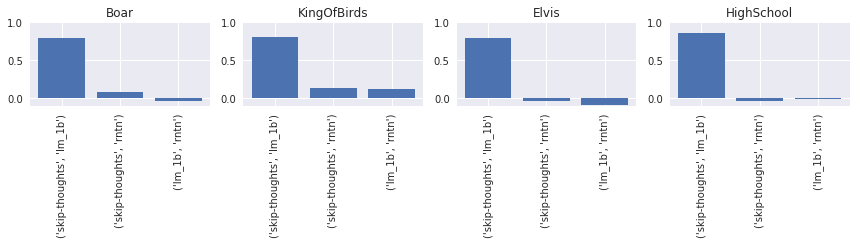

In [12]:
import itertools

from brainscore.metrics.rdm import RDM, RDMSimilarity

rdm = RDM()
similarity = RDMSimilarity()
model_combinations = list(itertools.combinations(models, 2))

fig, axes = pyplot.subplots(1, len(stories), figsize=(12, 3.5))
for story, ax in zip(stories, axes):
    scores = {}
    for model_combination in model_combinations:
        encodings = (get_activations(model, 'naturalistic-neural-reduced.{}'.format(story))
                     for model in model_combination)
        similarities = [rdm(encoding) for encoding in encodings]
        score = similarity(*similarities)
        scores[model_combination] = score
    print(scores)
    x, y = list(scores.keys()), list(scores.values())
    ax.bar(range(len(x)), y)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(list(map(str, x)), rotation='vertical')
    ax.set_ylim(-.1, 1)
    ax.set_title(story)
fig.tight_layout()
fig.show()
pyplot.savefig('results/scores-intermodel.svg')
pyplot.savefig('results/scores-intermodel.png')


## Model-region similarities

/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


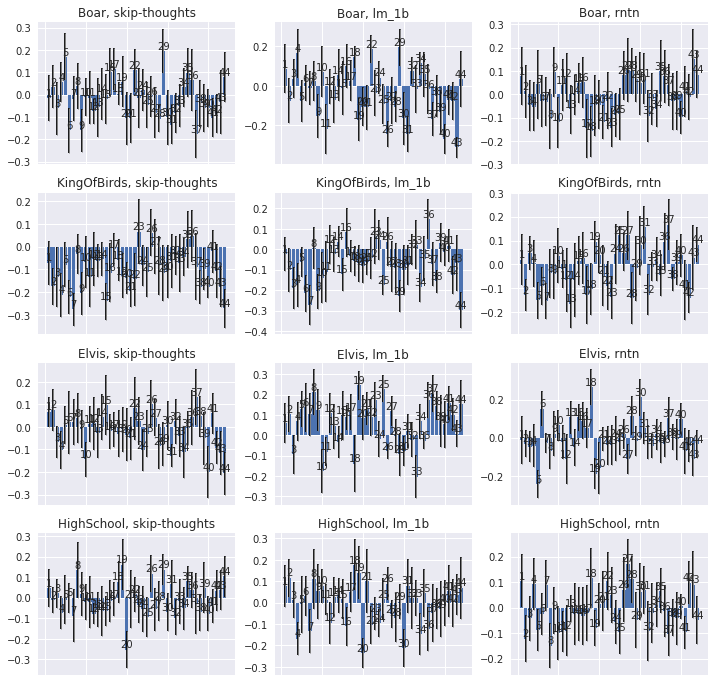

In [20]:
from neural_nlp import run

region_selection = [32, 40, 22, 34, 35, 6] + [36, 23, 2, 4, 18, 24, 39, 13, 9, 20, 10, 12]  
# left hemisphere language network + default mode network

fig, axes = pyplot.subplots(len(stories), len(models), figsize=(12, 12))

for i, story in enumerate(stories):
    for j, model in enumerate(models):
        ax = axes[i, j]
        ax.set_title("{}, {}".format(story, model))
        score = run(model, 'naturalistic-neural-reduced.{}'.format(story))
        score = score.aggregation
        regions = score['region'].values
        y, yerr = score.sel(aggregation='center'), score.sel(aggregation='error')
        bar = ax.bar(regions, y, yerr=yerr)
        ax.errorbar(regions, y, yerr=yerr, linestyle='None', color='gray', elinewidth=1)
        ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')

        for rect, region in zip(bar.patches, regions):
            ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(),
                    region, ha='center', va='bottom')

pyplot.savefig('results/scores-neural.svg')
pyplot.savefig('results/scores-neural.png')
fig
